In [130]:
import numpy as np
import pandas as pd

In [131]:
def extract_elof_genes(row):
    if (row['pLI'] > 0.9
            and row['oe_lof_upper'] < 0.35
            and row['pHaplo'] > 0.86):
        return True
    else:
        return False 

def extract_g2pLoF_genes(x):
    if 'absent gene product' in x:
        return 'PASS'
    else:
        return '.'

def extract_definitive(x):
    if x == 'definitive':
        return 'PASS'
    else:
        return '.'

def extract_strong(x):
    if (x == 'definitive' or x == 'strong'):
        return 'PASS'
    else:
        return '.'

def extract_moderate(x):
    if (x == 'definitive' or x == 'strong' or x == 'moderate'):
        return 'PASS'
    else:
        return '.'

In [132]:
### Lodading canonical transcripts
canonlist = '../01_CanonicalTranscripts/CanonicalTranscripts.exoncount.tsv'
canon = pd.read_table(canonlist, sep='\t', header=0)
canon_set = set(canon['ENST'])

# Curation data
ajhg_path = 'AJHG_ClinGenLoF_genes.txt.gz'
hi_path = 'ClinGen_haploinsufficiency_gene_GRCh37.bed'
gnomad_path = 'gnomad.v2.1.1.lof_metrics.by_gene.txt.gz'
phaplo_path = 'Collins_rCNV_2022.dosage_sensitivity_scores.tsv.gz'

# G2P data
dd = './DDG2P.csv.gz'
eye = './EyeG2P.csv.gz'
skin = './SkinG2P.csv.gz'
cancer = './CancerG2P.csv.gz'
cardiac = './CardiacG2P.csv.gz'
skeletal = './SkeletalG2P.csv.gz'

# Validation set
am_path = 'AlphaMissense_gene_hg19.tsv.gz'
genovo_path = 'GenovoLOEUF.txt.gz'
gnocchi_path = 'EnhancerGnocchi.txt.gz'

# Load data
ajhg = pd.read_csv(
    ajhg_path, sep='\t', header=None, skiprows=1,
    names=['gene', 'pLI', 'RefSeq', 'SpliceAcceptor', 'SpliceDonor'],
    usecols=['gene', 'RefSeq']) 

higene = pd.read_csv(
    hi_path, sep='\t', header=None, skiprows=1,
    names=['CHROM', 'start', 'end', 'gene', 'HIscore'],
    usecols=['gene', 'HIscore']
    ) 

gnomad = pd.read_csv(
    gnomad_path, sep='\t', compression='gzip',
    usecols=['gene', 'pLI', 'oe_lof_upper', 'transcript', 'cds_length']
    )

gnomad['is_canon'] = gnomad['transcript'].apply(
    lambda x: True if x in canon_set else False)

phaplo = pd.read_csv(
    phaplo_path, sep='\t', header=None, compression='gzip', skiprows=1,
    names=['gene', 'pHaplo', 'pTriplo'],
    usecols=['gene', 'pHaplo']
    ) 

gnomad = pd.merge(gnomad, phaplo, how='left',
                  left_on='gene', right_on='gene')

# Create a set of union of ajhg , higene and gnomad genes
all_genes_set = set(ajhg['gene']).union(set(higene['gene'])).union(set(gnomad['gene']))

### Select estimated Loss of Function genes
gnomad['is_eLoF'] = gnomad.apply(extract_elof_genes, axis=1)

#### Extract non-canonical ENST and shorter cds transcript from duplicated genes
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000368073')] 
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000608209')] 

dddf = pd.read_csv(dd, sep=',', header=0, compression='infer')
eyedf = pd.read_csv(eye, sep=',', header=0, compression='infer')
skidf = pd.read_csv(skin, sep=',', header=0, compression='infer')
candf = pd.read_csv(cancer, sep=',', header=0, compression='infer')
cardf = pd.read_csv(cardiac, sep=',', header=0, compression='infer')
skedf = pd.read_csv(skeletal, sep=',', header=0, compression='infer')
dfs = [dddf, eyedf, skidf, candf, cardf, skedf]

genovo = pd.read_csv(
    genovo_path, sep='\t', compression='gzip',
    usecols=['enstID', 'enstVersion', 'genovo_LOEUF_corrected']
    )

gnocchi = pd.read_csv(
    gnocchi_path, sep='\t', compression='gzip',
    usecols=['gene', 'enhancer_Gnocchi']
    )

am = pd.read_csv(am_path, sep='\t', compression='gzip', skiprows=3)
am['enstID'] = am['transcript_id'].str.split('.').str[0]
am['version'] = am['transcript_id'].str.split('.').str[1]
am.drop(columns=['transcript_id'], inplace=True)
am = am[['enstID', 'version', 'mean_am_pathogenicity']]

rename_cols = {
    'gene symbol': 'gene',
    'prev symbols': 'prev_symbols', 
    'hgnc id': 'hgnc_id',
    'gene mim': 'gene_mim', 
    'mutation consequence': 'mutation_consequence',
    'confidence category': 'confidence_category',
    'allelic requirement': 'allelic_requirement', 
    'disease name': 'disease_name'
    }

pickup_cols = [
    'gene', 'prev_symbols', 'hgnc_id',  
    'mutation_consequence', 'confidence_category', 
    'allelic_requirement', 'panel', 'disease_name', 
    'g2pLoF', 'definitiveFILTER', 'strongFILTER','moderateFILTER'
    ]

In [133]:
for df in dfs:
    df['g2pLoF'] = df['mutation consequence'].apply(extract_g2pLoF_genes)

for df in dfs:
    df['definitiveFILTER'] = df['confidence category'].apply(extract_definitive)
    df['strongFILTER'] = df['confidence category'].apply(extract_strong)
    df['moderateFILTER'] = df['confidence category'].apply(extract_moderate)

### Rename columns
dddf = dddf.rename(columns=rename_cols)
eyedf = eyedf.rename(columns=rename_cols)
skidf = skidf.rename(columns=rename_cols)
candf = candf.rename(columns=rename_cols)
cardf = cardf.rename(columns=rename_cols)
skedf = skedf.rename(columns=rename_cols)

### Extract columns for analysis
dddf = dddf[pickup_cols]
eyedf = eyedf[pickup_cols]
skidf = skidf[pickup_cols]
candf = candf[pickup_cols]
cardf = cardf[pickup_cols]
skedf = skedf[pickup_cols]

### Extract LoF genes
lof_dd = dddf[dddf['g2pLoF'] == 'PASS']
lof_eye = eyedf[eyedf['g2pLoF'] == 'PASS']
lof_ski = skidf[skidf['g2pLoF'] == 'PASS']
lof_can = candf[candf['g2pLoF'] == 'PASS']
lof_car = cardf[cardf['g2pLoF'] == 'PASS']
lof_ske = skedf[skedf['g2pLoF'] == 'PASS']

### Concatnate dataframes
alldf = pd.concat([lof_dd, lof_eye, lof_ski, lof_can, lof_car, lof_ske])
alldf.fillna(value='.', inplace=True)

### Extract genes with strong evidence
alldf_filterd = alldf[alldf['strongFILTER'] == 'PASS']
alldf_filterd = alldf_filterd.drop_duplicates(subset='gene')

# Gene lists from 4 sources
ajhg_genes = ajhg['gene']
dcpr_genes = alldf_filterd['gene']
hi_genes = higene.loc[higene['HIscore'] == 3, 'gene']
gnomad_genes = gnomad.loc[gnomad['is_eLoF'] == True, 'gene']
elofs = set(gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)

# Print number of genes in each list
print('AJHG:', len(ajhg_genes))
print('DCPR:', len(dcpr_genes))
print('HI:', len(hi_genes))
print('phaplo:', len(gnomad_genes))



AJHG: 1043
DCPR: 1832
HI: 347
phaplo: 1851


In [134]:
all_genes = pd.DataFrame(all_genes_set, columns=['gene'])
all_genes['in_ajhg'] = all_genes['gene'].apply(lambda x: True if x in ajhg_genes.values else False)
all_genes['in_dcpr'] = all_genes['gene'].apply(lambda x: True if x in dcpr_genes.values else False)
all_genes['in_hi'] = all_genes['gene'].apply(lambda x: True if x in hi_genes.values else False)
all_genes['in_gnomad'] = all_genes['gene'].apply(lambda x: True if x in gnomad_genes.values else False)

# Merge canon
print(len(all_genes))
all_genes = pd.merge(all_genes, canon, how='left', left_on='gene', right_on='GeneSymbol')

# Annotate gnocchi score
all_genes = pd.merge(all_genes, gnocchi, how='left', left_on='gene', right_on='gene')

# Annotate genovo score
all_genes = pd.merge(all_genes, genovo, how='left', left_on='ENST', right_on='enstID')

# Annotate AM score
all_genes = pd.merge(all_genes, am, how='left', left_on='ENST', right_on='enstID')
print(len(all_genes))


19717
19754


In [135]:
gnocchi['in_analysis'] = gnocchi['gene'].apply(lambda x: True if x in all_genes['gene'].values else False)

In [136]:
gnocchi['is_constrained'] = gnocchi['enhancer_Gnocchi'].apply(lambda x: True if x >= 4 else False)
gnocchi['is_eLoF'] = gnocchi['gene'].apply(lambda x: True if x in elofs else False)

In [137]:
all_genes['dup'] = all_genes.duplicated(subset='gene', keep=False)
# all_genes.loc[(all_genes[''].isnull()),
#               ['gene', 'ENSG', 'in_ajhg', 'in_dcpr', 'in_hi', 'in_gnomad',
#                'enhancer_Gnocchi', 'ENST', 'enstID_x', 'enstID_y', 'genovo_LOEUF_corrected', 'mean_am_pathogenicity']]

In [140]:
all_genes['is_eLoF'] = all_genes['gene'].apply(lambda x: True if x in elofs else False)
all_genes['is_highGenovo'] = all_genes['genovo_LOEUF_corrected'].apply(lambda x: True if x < 0.35 else False)

# calucrrate odds ratio of eLoF genes in high genovo genes using scipy.stats
# Culculate 95& CI of odds ratio
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import f

# Create a contingency table
# |-----------------|-----------------|-----------------|
# |                 | High Genovo     | Not High Genovo |
# |-----------------|-----------------|-----------------|
# | eLoF            | a               | b               |
# | Not eLoF        | c               | d               |
# |-----------------|-----------------|-----------------|

a = all_genes.loc[(all_genes['is_eLoF'] == True) & (all_genes['is_highGenovo'] == True), 'gene'].count()
b = all_genes.loc[(all_genes['is_eLoF'] == True) & (all_genes['is_highGenovo'] == False), 'gene'].count()
c = all_genes.loc[(all_genes['is_eLoF'] == False) & (all_genes['is_highGenovo'] == True), 'gene'].count()
d = all_genes.loc[(all_genes['is_eLoF'] == False) & (all_genes['is_highGenovo'] == False), 'gene'].count()

contingency_table = np.array([[a, b], [c, d]])
odds_ratio, p_value = fisher_exact(contingency_table)
print('Odds ratio:', odds_ratio)
print('P-value:', p_value)

# Calculate 95% CI of odds ratio
log_odds_ratio = np.log(odds_ratio)
se = np.sqrt(1/a + 1/b + 1/c + 1/d)
z = norm.ppf(0.975)
ci = np.exp(log_odds_ratio + np.array([-1, 1]) * z * se)
print('95% CI:', ci)

# Calculate chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Chi-square:', chi2)
print('P-value:', p)

# Print table
print(contingency_table)


Odds ratio: 7.212616302298688
P-value: 0.0
95% CI: [6.64721787 7.82610635]
Chi-square: 2665.604039634598
P-value: 0.0
[[ 1717  1882]
 [ 1814 14341]]


In [154]:
# Distribution of mean_am_pathogenicity of eLoF genes and non-eLoF genes using plotly
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=all_genes.loc[all_genes['is_eLoF'] == True, 'mean_am_pathogenicity'], name='eLoF'))
fig.add_trace(go.Histogram(x=all_genes.loc[all_genes['is_eLoF'] == False, 'mean_am_pathogenicity'], name='Not eLoF'))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

# Stastical test of mean_am_pathogenicity of eLoF genes and non-eLoF genes using scipy.stats
# Two-sample t-test
import scipy.stats as stats
from scipy.stats import ttest_ind

# Drop NaN values
am_eLoF = all_genes.loc[all_genes['is_eLoF'] == True, 'mean_am_pathogenicity'].dropna()
am_not_eLoF = all_genes.loc[all_genes['is_eLoF'] == False, 'mean_am_pathogenicity'].dropna()

# Plot the correlation between genovo and AM
fig = px.scatter(all_genes, x='genovo_LOEUF_corrected', y='mean_am_pathogenicity', trendline='ols')

# Group by is_eLoF by color
fig = px.scatter(all_genes, x='genovo_LOEUF_corrected', y='mean_am_pathogenicity', color='is_eLoF', trendline='ols')
# 透過性の設定
fig.update_traces(marker=dict(size=5, opacity=0.2))


fig.show()


In [141]:
all_genes[all_genes['is_highGenovo'] == True]

,gene,in_ajhg,in_dcpr,in_hi,in_gnomad,CHROM,Start,End,Strand,GeneSymbol,...,enhancer_Gnocchi,enstID_x,enstVersion,genovo_LOEUF_corrected,enstID_y,version,mean_am_pathogenicity,dup,is_eLoF,is_highGenovo
1,ASXL3,True,True,True,True,chr18,31158182.0,31331159.0,+,ASXL3,...,1.679944,ENST00000269197,5.0,0.114183,ENST00000269197,5,0.323192,False,True,True
3,RAP1A,False,False,False,False,chr1,112162410.0,112259313.0,+,RAP1A,...,2.028495,ENST00000369709,3.0,0.242833,NaN,NaN,NaN,False,False,True
9,MDM2,False,False,False,True,chr12,69201956.0,69239324.0,+,MDM2,...,2.102898,ENST00000258149,5.0,0.104417,NaN,NaN,NaN,False,True,True
14,BAHD1,False,False,False,False,chr15,40733151.0,40760435.0,+,BAHD1,...,2.483262,ENST00000416165,1.0,0.180958,ENST00000416165,1,0.371313,False,False,True
15,WDFY4,False,False,False,False,chr10,49892917.0,50191001.0,+,WDFY4,...,2.529608,ENST00000325239,5.0,0.322113,ENST00000325239,5,0.315443,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19735,CYLD,False,True,True,True,chr16,50775996.0,50835846.0,+,CYLD,...,3.238137,ENST00000427738,3.0,0.095745,ENST00000427738,3,0.534911,False,True,True
19740,CDH22,False,False,False,False,chr20,44802377.0,44937137.0,-,CDH22,...,4.393527,ENST00000537909,1.0,0.262245,ENST00000537909,1,0.477248,False,False,True
19751,PLRG1,False,False,False,True,chr4,155456156.0,155471552.0,-,PLRG1,...,2.917470,ENST00000499023,2.0,0.099154,ENST00000499023,2,0.586544,False,True,True
19752,GRM1,False,True,False,False,chr6,146350197.0,146758737.0,+,GRM1,...,1.890703,ENST00000282753,1.0,0.345853,ENST00000282753,1,0.541924,False,True,True


ValueError: 'xerr' must not contain negative values

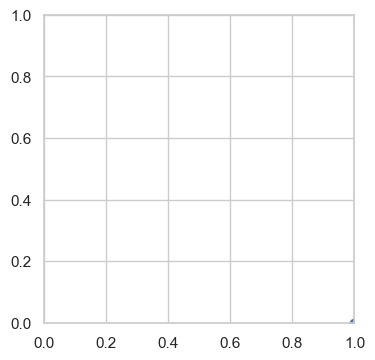

In [116]:
# Show forrest plot of odds ratio and 95% CI
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [77]:
am.loc[am['enstID'] == 'ENST00000614987']

,enstID,version,mean_am_pathogenicity


In [21]:
# Aggregate gene lists from 4 sources, named as genes
genes = pd.concat([ajhg_genes, dcpr_genes, hi_genes, gnomad_genes])
genes = genes.drop_duplicates()
print(len( genes.values))

3655


In [23]:
genes.values

array(['AAAS', 'AARS', 'AASS', ..., 'RASSF8', 'YBX1', 'HNRNPLL'],
      dtype=object)

In [24]:
def is_elof_gene(row, genecol: str):
    if row[genecol] in genes.values:
        return True
    else:
        return False

{'DKC1',
 'UBL3',
 'CSTF1',
 'PNP',
 'CHD9',
 'PSMC1',
 'DNASE1L2',
 'IQCC',
 'SEMA4D',
 'ORMDL1',
 'PCDHB13',
 'RFPL4B',
 'UBE4A',
 'SLCO1A2',
 'AVL9',
 'ZC3HAV1L',
 'DAAM2',
 'CCDC51',
 'TAS2R42',
 'SF3B14',
 'OTUD7A',
 'ADNP2',
 'ASB3',
 'SMC1B',
 'COL6A6',
 'CACNG1',
 'SNAI2',
 'CD81',
 'TFIP11',
 'STEAP3',
 'KCNK5',
 'CEBPG',
 'TMEM164',
 'CAMK2D',
 'KCTD17',
 'LDLRAD1',
 'STAMBPL1',
 'ZNF503',
 'PPAPDC1A',
 'ETFDH',
 'LSM10',
 'RSAD2',
 'CTU2',
 'ZNF621',
 'NLRP6',
 'CHRM3',
 'BIN2',
 'PLAC8',
 'PIK3R5',
 'NT5C',
 'FAM84B',
 'RP11-433C9.2',
 'FCGR2A',
 'CD97',
 'SLC39A10',
 'TCF15',
 'LRRC17',
 'GPR150',
 'RBMY1A1',
 'UVSSA',
 'FBXO48',
 'MTG1',
 'PSIP1',
 'BCL11B',
 'GRINA',
 'VPS25',
 'HS6ST1',
 'GJD2',
 'AC026202.1',
 'LARP1B',
 'LEFTY1',
 'FOSB',
 'LMLN',
 'PTPRJ',
 'TXK',
 'PRR16',
 'SPRR2E',
 'CHST8',
 'SMAP2',
 'RLF',
 'ANKEF1',
 'TPRN',
 'ATXN7L1',
 'RNF150',
 'RRAGC',
 'GNB5',
 'SLC25A36',
 'FANCG',
 'C15orf32',
 'RARRES2',
 'CRYGN',
 'CWF19L1',
 'SLC9B1P1',
 'CLPTM1',
 

In [25]:
# Create dataframe (Gene, enhancer_Gnocchi, is_elof)
gnocchi['is_elof'] = gnocchi.apply(is_elof_gene, axis=1, genecol='gene')

# Add enhancer_Gnocchi prediction column (enhan_Gnocchi ≥ 4.0)
gnocchi['enhancer_Gnocchi'] = gnocchi['enhancer_Gnocchi'].astype(float)
gnocchi['is_constrained'] = np.where(gnocchi['enhancer_Gnocchi'] >= 4.0, True, False)


In [29]:
# Show not elof genes with enhancer_Gnocchi ≥ 4.0
gnocchi.loc[(gnocchi['is_elof'] == False) & (gnocchi['is_constrained'] == True), ['gene', 'enhancer_Gnocchi']]

# Show elof genes with enhancer_Gnocchi < 4.0
gnocchi.loc[(gnocchi['is_elof'] == True) & (gnocchi['is_constrained'] == False), ['gene', 'enhancer_Gnocchi']]


,gene,enhancer_Gnocchi
1,SAMD11,1.579239
11,B3GALT6,2.723454
28,GNB1,-2.010407
34,PEX10,1.620286
37,PANK4,2.775673
...,...,...
15499,NOTCH1,3.348085
15514,ABCA2,1.520249
15518,GRIN1,3.894601
15537,ZMYND19,2.448615


In [32]:
# Odd ratio of elof genes with enhancer_Gnocchi ≥ 4.0 with 95 % confidence interval
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

# Create contingency table
table = pd.crosstab(gnocchi['is_elof'], gnocchi['is_constrained'])

# Fisher's exact test
oddsratio, pvalue = fisher_exact(table)
print('Odds ratio:', oddsratio)
print('P-value:', pvalue)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(table)
print('Chi-square:', chi2)
print('P-value:', p)
print('Degree of freedom:', dof)
print('Expected:', expected)

# Show adds ratio with 95 % confidence interval
import statsmodels.api as sm
oddsratio, ci = sm.stats.Table2x2(table).oddsratio_confint()
print('Odds ratio:', oddsratio)
print('95 % confidence interval:', ci)



Odds ratio: 1.090653887721789
P-value: 0.11070807387128559
Chi-square: 2.489744755210526
P-value: 0.11459030730453966
Degree of freedom: 1
Expected: [[10445.81146644  1901.18853356]
 [ 2702.18853356   491.81146644]]
Odds ratio: 0.9809926300910985
95 % confidence interval: 1.2125737404288062


In [30]:
print(f"non_elof: {len(gnocchi[gnocchi['is_elof'] == False])}")
print(f"elof: {len(gnocchi[gnocchi['is_elof'] == True])}")
print(f"constrained: {len(gnocchi[gnocchi['is_constrained'] == True])}")
print(f"non_constrained: {len(gnocchi[gnocchi['is_constrained'] == False])}")

non_elof: 12347
elof: 3194
constrained: 2393
non_constrained: 13148


In [18]:
# Culculate odds ratio and 95% confidence interval
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

# Create 2x2 table
table = pd.crosstab(gnocchi['is_elof'], gnocchi['is_constrained'])
print(table)

# Calculate odds ratio and 95% confidence interval
oddsratio, pvalue = fisher_exact(table)
print(f"oddsratio: {oddsratio}")
print(f"pvalue: {pvalue}")

# Calculate chi-square test
chi2, p, dof, expected = chi2_contingency(table)
print(f"chi2: {chi2}")
print(f"p: {p}")
print(f"dof: {dof}")
print(f"expected: {expected}")


is_constrained  False  True 
is_elof                     
False           10475   1872
True             2673    521
oddsratio: 1.090653887721789
pvalue: 0.11070807387128559
chi2: 2.489744755210526
p: 0.11459030730453966
dof: 1
expected: [[10445.81146644  1901.18853356]
 [ 2702.18853356   491.81146644]]


In [19]:
2673 + 521

3194

In [17]:
# Curation set
print('Curation set')
print('--- AJHG ---')
print(ajhg.head(3))
print(ajhg['gene'].nunique())
print('\n--- gnomAD ---')
print(gnomad.head(3))
print(gnomad['gene'].nunique())
print('\n--- HI ---')
print(higene.head(3))
print(higene['gene'].nunique())
print('\n--- Phaplo ---')
print(phaplo.head(3))
print(phaplo['gene'].nunique())


Curation set
--- AJHG ---
   gene       RefSeq
0  AAAS  NM_015665.5
1  AARS  NM_001605.2
2  AASS  NM_005763.3
1043

--- gnomAD ---
    gene       transcript  pLI  oe_lof_upper  cds_length
0  MED13  ENST00000397786  1.0         0.030        6522
1  NIPBL  ENST00000282516  1.0         0.032        8412
2   SMC3  ENST00000361804  1.0         0.037        3651
19658

--- HI ---
      gene  HIscore
0     AGRN       30
1  B3GALT6       30
2     GNB1        1
1500

--- Phaplo ---
      gene    pHaplo
0  CACNA1C  0.998982
1   ZNF462  1.000000
2     CHD8  0.991650
18641


In [19]:
print('Validation set')
print('--- AlphaMissense ---')
print(am.head(3))
print(am['enstID'].nunique())
print('\n--- Gnocchi ---')
print(gnocchi.head(3))
print(gnocchi['gene'].nunique())
print('\n--- Genovo ---')
print(genovo.head(3))
print(genovo['enstID'].nunique())

Validation set
--- AlphaMissense ---
            enstID version  mean_am_pathogenicity
0  ENST00000000233       5               0.742270
1  ENST00000000412       3               0.378343
2  ENST00000001008       4               0.422290
18761

--- Gnocchi ---
     gene  enhancer_Gnocchi
0   NOC2L          1.509945
1  SAMD11          1.579239
2  RNF223          2.725941
15541

--- Genovo ---
            enstID  enstVersion  genovo_LOEUF_corrected
0  ENST00000394484            1                0.000000
1  ENST00000329516            3                0.039973
2  ENST00000330331            5                0.071441
57308


In [21]:
# Merge AlphaMissense and Genovo data by enstID
am_genovo = pd.merge(am, genovo, on='enstID', how='inner')
print('\n--- AlphaMissense + Genovo ---')
print(am_genovo.head(3))
print(am_genovo['enstID'].nunique())



--- AlphaMissense + Genovo ---
            enstID version  mean_am_pathogenicity  enstVersion  \
0  ENST00000000233       5               0.742270            5   
1  ENST00000000412       3               0.378343            3   
2  ENST00000001008       4               0.422290            4   

   genovo_LOEUF_corrected  
0                0.109528  
1                0.787049  
2                0.524644  
16355


In [73]:
merged_gnocchi = gnocchi[gnocchi['tissue'] == 'Merged']
genelist = list(merged_gnocchi['gene'] )

In [76]:
raw_genelist = list(gnocchi['gene'].unique())

In [78]:
# comparison of gene lists (genelist vs. raw_genelist)
print(len(genelist))
print(len(raw_genelist))

# substraction of gene lists
diff = list(set(raw_genelist) - set(genelist))
print(diff)

15541
15860
['DCAF4L2', 'TAS2R20', 'ADAM8', 'SPTLC1', 'CALML5', 'USP17L17', 'C11orf94', 'CNOT3', 'NRG1', 'SPHAR', 'DDX11', 'C3orf56', 'ZNF382', 'SLC25A11', 'ZDHHC24', 'OR2M5', 'OR1N1', 'OR2T8', 'PAGR1', 'KRTAP12-1', 'SUMO4', 'CSF3', 'LCE6A', 'SPATA12', 'CCDC15', 'AGBL3', 'IFNA4', 'TAS2R42', 'LCE4A', 'HUS1B', 'CTAGE4', 'GPR84', 'ZNF497', 'COPS6', 'OR14A16', 'CEMP1', 'DIRAS3', 'TAS2R31', 'FAM170A', 'STH', 'TAS2R14', 'ZNF860', 'DNPH1', 'CCAR2', 'NR2E3', 'CTAGE8', 'IFNA8', 'FITM1', 'HIST2H3C', 'LENG9', 'OR7C1', 'UFC1', 'TIAF1', 'IFNB1', 'TYSND1', 'DVL2', 'KMT2B', 'CHRNB1', 'CARD6', 'OGDHL', 'HIST2H4B', 'OR14K1', 'IFNA21', 'TAS2R1', 'CCT6A', 'SYTL1', 'SRRM5', 'FPR1', 'HRCT1', 'MRGPRD', 'KIR3DX1', 'PTPN6', 'MANEAL', 'TAF1C', 'PTTG2', 'FAM218A', 'NDUFB10', 'TAS2R60', 'VN1R1', 'KRTAP4-3', 'CCDC177', 'KRTAP21-2', 'PM20D1', 'FAM71D', 'KRTDAP', 'PHGR1', 'MRGPRX1', 'PSAPL1', 'TRIM73', 'LRRN4CL', 'MRGPRX2', 'FPR3', 'ANAPC15', 'BLID', 'FRMD1', 'LCN6', 'NDUFA7', 'NPIPB5', 'PARP2', 'CFC1B', 'ZNF219', 

In [84]:
ascl2 = gnocchi[gnocchi['gene'] == 'ASCL2']
ascl2

,tissue,gene,ENSG,z
2126,ESC,ASCL2,ENSG00000183734,5.063194
31916,iPSC,ASCL2,ENSG00000183734,5.063194
47167,Blood_T-cell,ASCL2,ENSG00000183734,6.084149
47168,Digestive,ASCL2,ENSG00000183734,6.084149
67741,HSC_B-cell,ASCL2,ENSG00000183734,6.084149
108892,Epithelial,ASCL2,ENSG00000183734,5.521794
121319,Thymus,ASCL2,ENSG00000183734,6.084149
182268,PLACENTA,ASCL2,ENSG00000183734,5.521794
192625,PANCREAS,ASCL2,ENSG00000183734,5.569333
199282,LUNG,ASCL2,ENSG00000183734,6.084149


In [83]:
ascl2_without_merged = ascl2[ascl2['tissue'] != 'Merged']
mean_ascl2 = ascl2_without_merged['z'].mean()

print(mean_ascl2)

5.64469795825
